In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
#Import packages
#import gym
#import gym_uav
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from itertools import count
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [115]:
#Import Custom Classes

from Source.NN_model_2 import QNetwork
from Source.dqn_agent_2 import Agent, ReplayBuffer, EpsilonGreedyStrategy
from Source.Env_Manager import EnvManager
from Source.Misc import plot



In [116]:
#Hyper-parameters
BUFFER_SIZE = int(1e5)      #replay buffer size
BATCH_SIZE = 60             #minibatch size
GAMMA = 0.99                #discount factor
TAU = 1e-3                  #for soft update of target parameters
LR = 5e-3                   #learning rate
UPDATE_EVERY = 50            #how often to update the network
eps_start = 1
eps_end = 0.01
eps_decay = 125e-6
train_episodes = 8000
test_episodes = 1
seed = 0                    #random seed number

In [117]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Choose the environment
em = EnvManager(device, 'uav-v2', seed)
available_actions = em.num_actions_available()
random.seed(seed)


#Select the strategy
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

#Initialize the agent
agent = Agent(strategy, available_actions, seed, device)

#Instantiate MemoryBuffer
memory = ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, seed, device)

policy_net = QNetwork(available_actions, seed).to(device)
target_net = QNetwork(available_actions, seed).to(device)
print(policy_net)

#Initialize target_net weights to policy_net weights
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() #Set the target_net in eval mode

#Select the optimizer
optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)

QNetwork(
  (conv1): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=56, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=8, bias=True)
)


Testing Environment with untrained Agent

In [118]:
state = em.reset()
#state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
print(state.shape)
for j in range(5):
    action = agent.act(state, policy_net)
    print("action: ", action.item())
    #print("Action: {}, Qval: {}".format(action, qval))
    #env.render()
    #print("[NB] action: {}".format(action))
    state, reward, done, _ = em.step(action)
    #state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
    if done:
        break 
        
em.close()

torch.Size([1, 1, 7])
action:  6
action:  7
action:  4
action:  5
action:  3


Training the DQN Agent

Episode 7999	 Score: -7.13


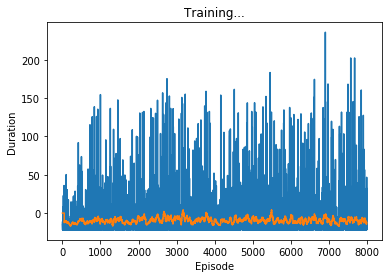

Episode 8000 
 50 episode moving avg: -12.149567


In [119]:
#Training Loop
episode_durations = []
episode_rewards = []
policy_net.train()
for episode in range(train_episodes):
    state = em.reset()
    
    #state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
    ep_loss = 0.0
    ep_rwd = 0.0
    for timestep in count():
        action = agent.act(state, policy_net)
        next_state, reward, done, _ = em.step(action)
        ep_rwd += reward.item()
        memory.add(state, action, reward, next_state, done)
        
        state = next_state
        #state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        if memory.can_provide_sample():
            experiences = memory.sample()
            states, actions, rewards, next_states, dones = experiences
            
            #print(states.shape, states.dtype)
            #print(actions.unsqueeze(-1).shape)
            current_q_values = policy_net.forward(states).gather(1,index=actions.unsqueeze(-1))
            next_q_values = target_net.forward(next_states).detach().max(1)[0]
            target_q_values = (next_q_values*GAMMA) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            #print("loss: ", loss.item())
            ep_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if timestep==10 or done:
            episode_durations.append(timestep)
            episode_rewards.append(ep_rwd)
            print('\rEpisode {}\t Score: {:.2f}'.format(episode, ep_rwd))
            plot(episode_rewards, 50)
            break
        
    if episode % UPDATE_EVERY == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    if np.mean(episode_rewards[-50:]) >= 100:
        print("Goal is reached!\n")
        break
        
    torch.save(policy_net.state_dict(), 'checkpoint.pth')
    em.close()

Testing the DQN agent

In [120]:
#Load the weights from file
policy_net.load_state_dict(torch.load('checkpoint.pth'))

rate_acc_los_scores = []
rate_acc_exh_scores = []
learnt_val_fns = []
true_val_fns = []
test_scores = []
policy_net.eval()
for i_episode in range(1, test_episodes+1):
    
    learnt_rates = 0.0
    los_rates = 0.0
    exh_rates = 0.0
    state_tensor = em.reset()
    learnt_val_fn = 0.0
    true_val_fn = 0.0
    perf_score = 0
    for t_step in count():
        action = policy_net(state_tensor).argmax(dim=1).to(device)#agent.act(state_tensor, policy_net)
        
        next_state_tensor, reward, done, _ = em.step(action)
        
        
        state = np.rint(state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
        next_state = np.rint(next_state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
        print("Current State: ", state)
        print("Next State: ", next_state)

        curr_loc = (state[0], state[1])
        next_loc = (next_state[0], next_state[1])
        #print("Test Episode: {2}, Current Location: {0}, Next Location: {1}".format(curr_loc, next_loc, i_episode))
        #print("Learnt Action: ", test_net(state))
        
            
        next_state = next_state / em.env.high_obs
        
        state_tensor = torch.tensor(np.array([[next_state]]), dtype=torch.float32).to(device)
        
        
        
        #rate measurements
        learnt_rate = em.env.get_Rate()
        _,los_rate = em.env.get_Los_Rate(next_state)
        exh_bdir,exh_rate = em.env.get_Exh_Rate(next_state)
        
        if (learnt_rate > em.env.rate_threshold):
            perf_score +=1
        learnt_val_fn += ((GAMMA**(t_step)) * (learnt_rate))
        true_val_fn += ((GAMMA**(t_step)) * (exh_rate))
        
        print("exh dir: {0}, learnt bdir: {1}".format(exh_bdir, em.env.BeamSet[action]))
        print("Rwd: {3}, Learnt Rate: {0}, Exh_Rate: {1}, Los_Rate: {2}\n\n".format(learnt_rate, exh_rate, los_rate, reward))
        
        if (t_step==20) or done:
            break
        '''
        
        #Move to next_state
        state = next_state
        
        learnt_rates += learnt_rate
        los_rates += los_rate
        exh_rates += exh_rate
        
        if done:
            rate_acc_los = learnt_rates/ los_rates
            rate_acc_exh = learnt_rates / exh_rates
            rate_acc_los_scores.append(rate_acc_los)
            rate_acc_exh_scores.append(rate_acc_exh)
            learnt_val_fns.append(learnt_val_fn)
            true_val_fns.append(true_val_fn)
            test_scores.append(perf_score)
            #writer.add_scalar("test/rate_acc_los", rate_acc_los, i_episode)
            #writer.add_scalar("test/rate_acc_exh", rate_acc_exh, i_episode)
            print('\rEpisode {}\tRate_acc_los Score: {:.2f}\tRate_acc_exh Score: {:.2f}\t perf_score: {:.2f}'.format(i_episode, rate_acc_los, rate_acc_exh, perf_score, end=""))
            print("\n\n")
            break
        '''
print("Total Epsiodes {},Average Rate_Acc_los: {:.2f}, Average Rate_Acc_exh: {:.2f}\n".format(test_episodes, np.mean(rate_acc_los_scores), np.mean(rate_acc_exh_scores)))

Current State:  [450. 200.  50. -50.   2. 450. 450.]
Next State:  [500. 150.  50. -50.   3. 450. 450.]
exh dir: 0.7853981633974483, learnt bdir: 3.141592653589793
Rwd: tensor([-2.], device='cuda:0'), Learnt Rate: 0.004986728841065182, Exh_Rate: 0.002499162342736102, Los_Rate: 0.0026970743534101916


Current State:  [500. 150.  50. -50.   3. 450. 450.]
Next State:  [550. 100.  50. -50.   3. 450. 450.]
exh dir: 0.7853981633974483, learnt bdir: 3.141592653589793
Rwd: tensor([-2.], device='cuda:0'), Learnt Rate: 0.0047147038344258554, Exh_Rate: 0.0020749373403883453, Los_Rate: 0.0022363798933874935


Current State:  [550. 100.  50. -50.   3. 450. 450.]
Next State:  [600.  50.  50. -50.   3. 450. 450.]
exh dir: 0.7853981633974483, learnt bdir: 3.141592653589793
Rwd: tensor([-2.], device='cuda:0'), Learnt Rate: 0.004128805643518013, Exh_Rate: 0.0017432356616382504, Los_Rate: 0.001880990748660168


Current State:  [600.  50.  50. -50.   3. 450. 450.]
Next State:  [650.   0.  50. -50.   3. 450

Compute the value function

In [121]:
#Load the weights from file
policy_net.load_state_dict(torch.load('checkpoint.pth'))
test_episodes = 20

rate_acc_los_scores = []
rate_acc_exh_scores = []
learnt_val_fns = []
true_val_fns = []
test_scores = []
policy_net.eval()
for i_episode in range(1, test_episodes+1):
    
    learnt_rates = 0.0
    los_rates = 0.0
    exh_rates = 0.0
    state_tensor = em.reset()
    learnt_val_fn = 0.0
    true_val_fn = 0.0
    perf_score = 0
    for t_step in count():
        action = policy_net(state_tensor).argmax(dim=1).to(device)#agent.act(state_tensor, policy_net)
        
        next_state_tensor, reward, done, _ = em.step(action)
        
        
        state = np.rint(state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
        next_state = np.rint(next_state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
        #print("Current State: ", state)
        #print("Next State: ", next_state)

        curr_loc = (state[0], state[1])
        next_loc = (next_state[0], next_state[1])
        #print("Test Episode: {2}, Current Location: {0}, Next Location: {1}".format(curr_loc, next_loc, i_episode))
        #print("Learnt Action: ", test_net(state))
        
            
        next_state = next_state / em.env.high_obs
        
        state_tensor = torch.tensor(np.array([[next_state]]), dtype=torch.float32).to(device)
        
        
        
        #rate measurements
        learnt_rate = em.env.get_Rate()
        _,los_rate = em.env.get_Los_Rate(next_state)
        exh_bdir,exh_rate = em.env.get_Exh_Rate(next_state)
        
        if (learnt_rate > em.env.rate_threshold):
            perf_score +=1
        learnt_val_fn += ((GAMMA**(t_step)) * (learnt_rate))
        true_val_fn += ((GAMMA**(t_step)) * (exh_rate))
        
        learnt_rates += learnt_rate
        exh_rates += exh_rate
        los_rates += los_rate
        #print("exh dir: {0}, learnt bdir: {1}".format(exh_bdir, em.env.BeamSet[action]))
        #print("Rwd: {3}, Learnt Rate: {0}, Exh_Rate: {1}, Los_Rate: {2}\n\n".format(learnt_rate, exh_rate, los_rate, reward))
        
        if (t_step==10) or done:
            rate_acc_los = learnt_rates/ los_rates
            rate_acc_exh = learnt_rates / exh_rates
            rate_acc_los_scores.append(rate_acc_los)
            rate_acc_exh_scores.append(rate_acc_exh)
            learnt_val_fns.append(learnt_val_fn)
            true_val_fns.append(true_val_fn)
            break

Current State:  [-300.  450.   50.  100.    2.  450.  450.]
Next State:  [-250.  550.   50.  100.    3.  450.  450.]
Current State:  [-250.  550.   50.  100.    3.  450.  450.]
Next State:  [-200.  650.   50.  100.    3.  450.  450.]
Current State:  [-200.  650.   50.  100.    3.  450.  450.]
Next State:  [-150.  750.   50.  100.    3.  450.  450.]
Current State:  [-150.  750.   50.  100.    3.  450.  450.]
Next State:  [-100.  850.   50.  100.    3.  450.  450.]
Current State:  [-100.  850.   50.  100.    3.  450.  450.]
Next State:  [-50. 950.  50. 100.   3. 450. 450.]
Current State:  [-50. 950.  50. 100.   3. 450. 450.]
Next State:  [   0. 1050.   50.  100.    3.  450.  450.]
Current State:  [   0. 1050.   50.  100.    3.  450.  450.]
Next State:  [  50. 1150.   50.  100.    3.  450.  450.]
Current State:  [  50. 1150.   50.  100.    3.  450.  450.]
Next State:  [ 100. 1250.   50.  100.    3.  450.  450.]
Current State:  [ 100. 1250.   50.  100.    3.  450.  450.]
Next State:  [ 150

Current State:  [600. 900. 100.  50.   3. 450. 450.]
Next State:  [700. 950. 100.  50.   3. 450. 450.]
Current State:  [700. 950. 100.  50.   3. 450. 450.]
Next State:  [ 800. 1000.  100.   50.    3.  450.  450.]
Current State:  [ 800. 1000.  100.   50.    3.  450.  450.]
Next State:  [ 900. 1050.  100.   50.    3.  450.  450.]
Current State:  [  0. 450.  50.  50.   2. 450. 450.]
Next State:  [ 50. 500.  50.  50.   1. 450. 450.]
Current State:  [ 50. 500.  50.  50.   1. 450. 450.]
Next State:  [100. 550.  50.  50.   1. 450. 450.]
Current State:  [100. 550.  50.  50.   1. 450. 450.]
Next State:  [150. 600.  50.  50.   1. 450. 450.]
Current State:  [150. 600.  50.  50.   1. 450. 450.]
Next State:  [200. 650.  50.  50.   1. 450. 450.]
Current State:  [200. 650.  50.  50.   1. 450. 450.]
Next State:  [250. 700.  50.  50.   1. 450. 450.]
Current State:  [250. 700.  50.  50.   1. 450. 450.]
Next State:  [300. 750.  50.  50.   1. 450. 450.]
Current State:  [300. 750.  50.  50.   1. 450. 450.]

Current State:  [-750.  500.  -50.   50.    1.  450.  450.]
Next State:  [-800.  550.  -50.   50.    1.  450.  450.]
Current State:  [-800.  550.  -50.   50.    1.  450.  450.]
Next State:  [-850.  600.  -50.   50.    1.  450.  450.]
Current State:  [-850.  600.  -50.   50.    1.  450.  450.]
Next State:  [-900.  650.  -50.   50.    1.  450.  450.]
Current State:  [-350.  250.  100.  100.    1.  450.  450.]
Next State:  [-250.  350.  100.  100.    1.  450.  450.]
Current State:  [-250.  350.  100.  100.    1.  450.  450.]
Next State:  [-150.  450.  100.  100.    1.  450.  450.]
Current State:  [-150.  450.  100.  100.    1.  450.  450.]
Next State:  [-50. 550. 100. 100.   3. 450. 450.]
Current State:  [-50. 550. 100. 100.   3. 450. 450.]
Next State:  [ 50. 650. 100. 100.   3. 450. 450.]
Current State:  [ 50. 650. 100. 100.   3. 450. 450.]
Next State:  [150. 750. 100. 100.   3. 450. 450.]
Current State:  [150. 750. 100. 100.   3. 450. 450.]
Next State:  [250. 850. 100. 100.   3. 450. 45

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


[0.0002022495498053857, 0.00031533148809998986, 0.00022786720379677872, 0.000444356639347572, 0.005292197757620373, 0.001037550206314972, 0.0003117998983457132, 0.013996835969016271, 0.00019996807103736874, 0.02017502702024582, 0.21020547056310498, 0.00040511126836122895, 0.004523189810618564, 0.00018162562415660637, 0.00026453047357124696, 0.07158913733517498, 0.0008095519365569021, nan, nan, 0.0010762918651997073]
[nan, 0.3271934990946819, 0.013680025272082041, 0.023325848722973126, 0.037620784501965585, 0.29956927301209585, nan, 0.24567054522488002, 0.3271934990946819, 0.17504699210638305, nan, 0.008374933220417751, 0.3271934990946819, 0.01917079597832292, 0.32641733383925714, nan, 0.019170795978322885, nan, nan, nan]


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


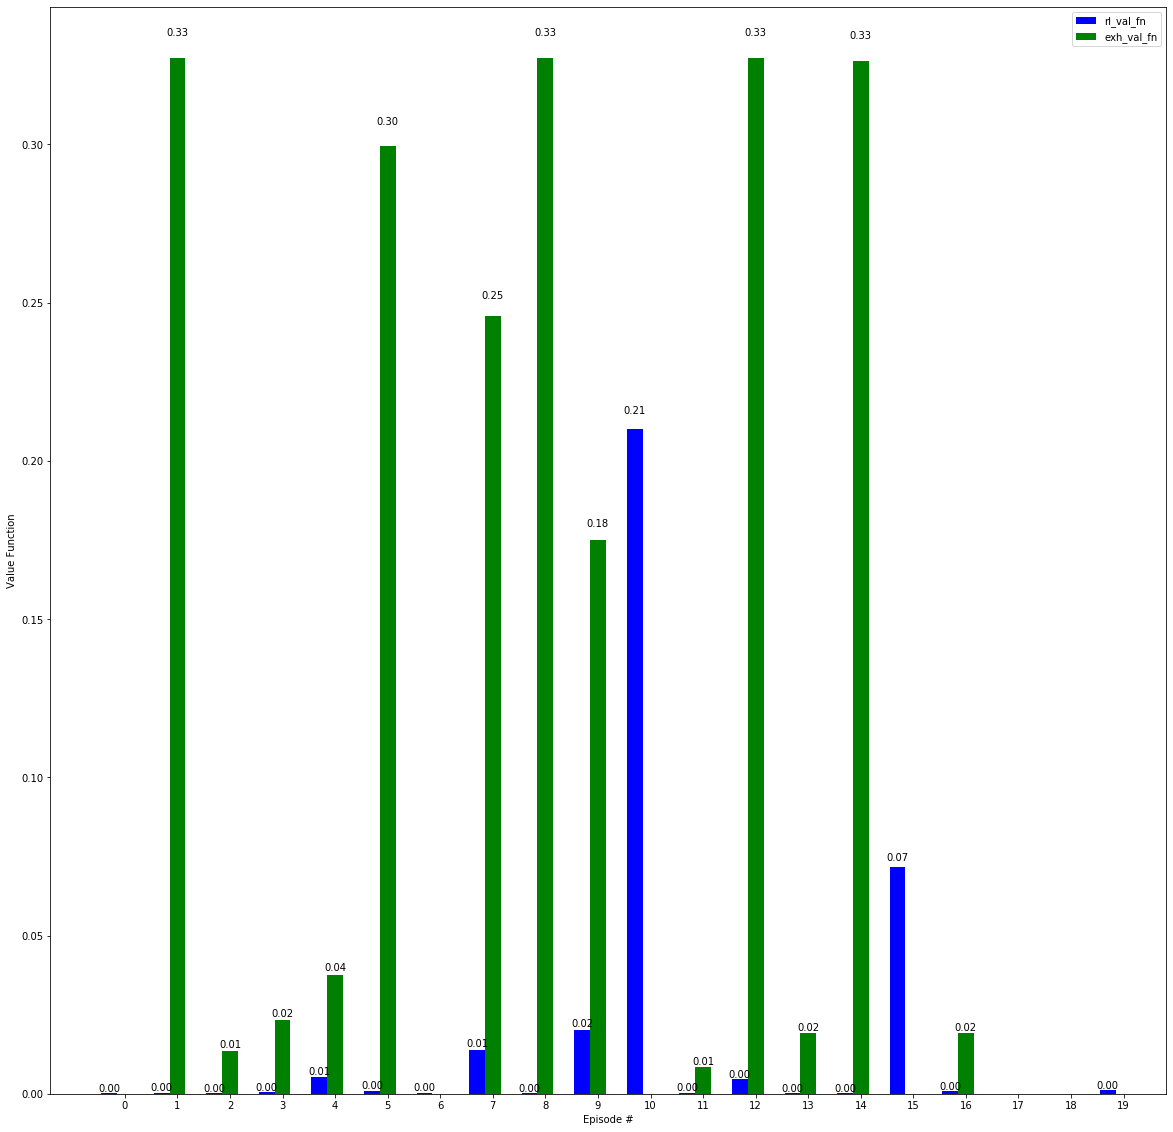

In [123]:
print(learnt_val_fns)
print(true_val_fns)




# plot the histogram
w=0.3
fig = plt.figure(figsize=(20,20))
x_axis = np.arange(test_episodes)
ax = fig.add_subplot(111)
rects1 = ax.bar(x_axis-w, learnt_val_fns, w, color='b')
rects2= ax.bar(x_axis, true_val_fns, w, color='g')
#plt.legend(loc='upper right')
ax.legend( (rects1[0], rects2[0]), ('rl_val_fn', 'exh_val_fn'), loc='upper right' )
plt.ylabel('Value Function')
plt.xlabel('Episode #')
ax.set_xticks(x_axis)

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.02*h, '%.2f'%np.around(h, decimals=2),
                ha='center', va='bottom')

ax.axhline(np.mean(learnt_val_fns), color='b', linewidth=0.75, linestyle='--')
ax.axhline(np.mean(true_val_fns), color='g', linewidth=0.75, linestyle='--')
autolabel(rects1)
autolabel(rects2)
plt.show()